# GRU

### LIBRERÍAS

In [7]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, TimeDistributed
from tensorflow.keras.losses import mean_squared_error

### CARGA DE COMPLETE RETURNS DF & WEATHER DF

In [8]:
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P.csv')

In [9]:
completeReturnsDf['Date'] = pd.to_datetime(completeReturnsDf['Date'])
completeReturnsDf.set_index('Date', inplace=True)

In [10]:
completeWeatherDf = pd.read_csv('../data/completeData/weather/completeWeatherDf.csv')

In [11]:
def getTrainValidationTestStationT24T48T168_ExogVariables(trainDays, validationDays, station, completeReturnsDf, completeWeatherDf):
    X_24 = np.delete(completeReturnsDf[[station]].values.reshape(-1, 24), [range(0, 6)], 0)
    X_48 = completeReturnsDf[[station]].values.reshape(-1, 24)
    X_48 = np.delete(X_48, [range(0, 5)], 0)
    X_48 = np.delete(X_48, len(X_48)-1, 0)
    X_168 = completeReturnsDf[[station]].values.reshape(-1, 24)
    X_168 = np.delete(X_168, [[len(X_168)-i for i in range(1, 7)]], 0)

    X_temp = np.delete(completeWeatherDf['temp'].values.reshape(-1, 24), [range(0, 7)], 0)
    X_humidity = np.delete(completeWeatherDf['humidity'].values.reshape(-1, 24), [range(0, 7)], 0)

    X = np.append( np.append( X_168, X_48, axis=1), X_24, axis = 1)
    X = np.delete(X, len(X)-1, 0)
    X = np.append( np.append( X_temp, X_humidity, axis=1), X, axis=1).reshape(-1,5, 24)

    X_transposed = np.empty((len(X), 24, 5))
    for i in range(0, len(X)):
        X_transposed[i] = X[i].transpose()

    X = X_transposed
    Y = np.delete(X_24, 0, 0)

    X_train, Y_train = X[0:trainDays], Y[0:trainDays]
    X_validation, Y_validation = X[trainDays:trainDays+validationDays], Y[trainDays:trainDays+validationDays]
    X_test , Y_test = X[trainDays+validationDays:X.shape[0]], Y[trainDays+validationDays:Y.shape[0]]

    print("Shape del dataframe 'X_train' --> {} // 'X_validation --> {} //  X_test --> {}".format(X_train.shape,X_validation.shape, X_test.shape))
    print("Shape del dataframe 'Y_train' --> {} // 'Y_validation --> {} // Y_test --> {}".format(Y_train.shape, Y_validation.shape, Y_test.shape))
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

In [12]:
def plotDayPrediction(predictions, Y, day, log1pData):

    data = pd.DataFrame()
    try:
        if log1pData:
            data['prediction'] = np.round(np.expm1(predictions[day]),0)
            data['real'] = np.expm1(Y[day])
        else:
            data['prediction'] = np.round(predictions[day],0)
            data['real'] = Y[day]
    except:
        print("El dia tiene que ser inferior a {}".format(len(Y)) )

    plt.figure(figsize=(12,5))
    plt.xlabel('Prediction of day ' + str(day))

    ax1 = data.prediction.plot(color='red', grid=True, label='Forecast')
    ax2 = data.real.plot(color='blue', grid=True, label='Actual')
    h1, l1 = ax1.get_legend_handles_labels()

    plt.legend(h1, l1, loc=2)
    plt.show()

In [13]:
def log1p_mse_rmse(Y_test, predictions):
    rmse = 0
    mse = 0
    for i in range(0, len(predictions)):
        mse += mean_squared_error(np.expm1(Y_test[i]), np.expm1(predictions[i]))

    mse /= len(predictions)
    rmse += math.sqrt(mse)
    print("MSE = {}, RMSE = {}".format(mse,rmse))

In [14]:
epochs = 10000
batch_size = 4096

### GRU CON DISTRIBUTED LAYER [MANY TO MANY] t-24h, t-48h & t-168h + Exogenous Variables


In [25]:
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = getTrainValidationTestStationT24T48T168_ExogVariables(4000, 102, '31201', completeReturnsDf, completeWeatherDf)

Shape del dataframe 'X_train' --> (4000, 24, 5) // 'X_validation --> (102, 24, 5) //  X_test --> (102, 24, 5)
Shape del dataframe 'Y_train' --> (4000, 24) // 'Y_validation --> (102, 24) // Y_test --> (102, 24)


#### MODELO SIMPLE LOG1P

In [28]:
model = Sequential()
model.add(GRU(X_train.shape[1], input_shape=(X_train.shape[1], 5), return_sequences=True, name='LSTM_1'))
model.add(TimeDistributed(Dense(1, activation="relu", name="Dense_1")))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (GRU)                 (None, 24, 24)            2232      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             25        
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1), batch_size=batch_size, epochs=epochs)

Epoch 1/10000
1/1 [==============================] - 1s 691ms/step - loss: 1.8851 - mae: 1.1398
Epoch 2/10000
1/1 [==============================] - 0s 32ms/step - loss: 1.8196 - mae: 1.1215
Epoch 3/10000
1/1 [==============================] - 0s 37ms/step - loss: 1.7537 - mae: 1.1030
Epoch 4/10000
1/1 [==============================] - 0s 34ms/step - loss: 1.6876 - mae: 1.0841
Epoch 5/10000
1/1 [==============================] - 0s 27ms/step - loss: 1.6224 - mae: 1.0652
Epoch 6/10000
1/1 [==============================] - 0s 26ms/step - loss: 1.5586 - mae: 1.0465
Epoch 7/10000
1/1 [==============================] - 0s 30ms/step - loss: 1.4971 - mae: 1.0280
Epoch 8/10000
1/1 [==============================] - 0s 31ms/step - loss: 1.4380 - mae: 1.0099
Epoch 9/10000
1/1 [==============================] - 0s 29ms/step - loss: 1.3818 - mae: 0.9923
Epoch 10/10000
1/1 [==============================] - 0s 27ms/step - loss: 1.3284 - mae: 0.9753
Epoch 11/10000
1/1 [============================

In [30]:
score = model.evaluate(X_validation, Y_validation.reshape(Y_validation.shape[0], Y_validation.shape[1], 1), batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))
predictions = model.predict(x=X_validation, batch_size=batch_size, verbose=0).reshape(-1, 24)
log1p_mse_rmse(Y_validation, predictions)

 Test rmse: 0.4714361948397039
 Test loss: 0.22225208580493927
 Test mae: 0.3590872287750244
MSE = 5.021055221557617, RMSE = 2.2407711220822213


MSE = 3.7326087951660156, RMSE = 1.9319960649975496


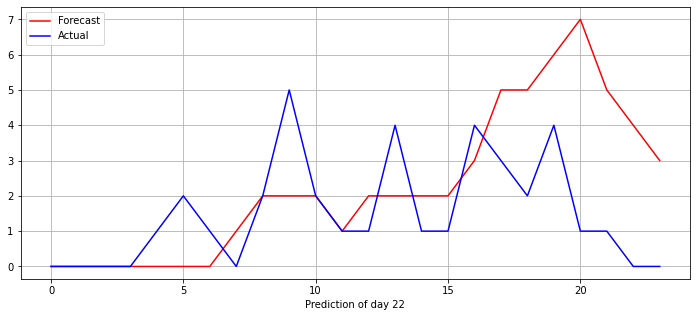

In [31]:
predictions = model.predict(x=X_test, batch_size=batch_size, verbose=0).reshape(-1,24)
log1p_mse_rmse(Y_test, predictions)
plotDayPrediction(predictions, Y_test, 22, True)

#### MODELO DENSO LOG1P

In [61]:
model = Sequential()
model.add(GRU(X_train.shape[1], input_shape=(X_train.shape[1], 5), return_sequences=True, name='LSTM_1'))
model.add(TimeDistributed(Dense(16, activation="relu", name="Dense_1")))
model.add(Dense(8, activation='relu', name='Dense_2'))
model.add(Dense(4, activation='relu', name='Dense_3'))
model.add(Dense(2, activation='relu', name='Dense_4'))
model.add(Dense(1, activation='relu', name='Dense_5'))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (GRU)                 (None, 24, 24)            2232      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 24, 16)            400       
_________________________________________________________________
Dense_2 (Dense)              (None, 24, 8)             136       
_________________________________________________________________
Dense_3 (Dense)              (None, 24, 4)             36        
_________________________________________________________________
Dense_4 (Dense)              (None, 24, 2)             10        
_________________________________________________________________
Dense_5 (Dense)              (None, 24, 1)             3         
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
___________________________________________________

In [62]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1), batch_size=batch_size, epochs=epochs)

Epoch 1/10000
1/1 [==============================] - 1s 848ms/step - loss: 2.6098 - mae: 1.3035
Epoch 2/10000
1/1 [==============================] - 0s 112ms/step - loss: 2.6010 - mae: 1.3015
Epoch 3/10000
1/1 [==============================] - 0s 47ms/step - loss: 2.5872 - mae: 1.2984
Epoch 4/10000
1/1 [==============================] - 0s 11ms/step - loss: 2.5661 - mae: 1.2940
Epoch 5/10000
1/1 [==============================] - 0s 9ms/step - loss: 2.5405 - mae: 1.2888
Epoch 6/10000
1/1 [==============================] - 0s 11ms/step - loss: 2.5097 - mae: 1.2829
Epoch 7/10000
1/1 [==============================] - 0s 10ms/step - loss: 2.4742 - mae: 1.2762
Epoch 8/10000
1/1 [==============================] - 0s 9ms/step - loss: 2.4339 - mae: 1.2684
Epoch 9/10000
1/1 [==============================] - 0s 11ms/step - loss: 2.3888 - mae: 1.2593
Epoch 10/10000
1/1 [==============================] - 0s 9ms/step - loss: 2.3397 - mae: 1.2490
Epoch 11/10000
1/1 [==============================

In [63]:
score = model.evaluate(X_validation, Y_validation.reshape(Y_validation.shape[0], Y_validation.shape[1], 1), batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))
predictions = model.predict(x=X_validation, batch_size=batch_size, verbose=0).reshape(-1, 24)
log1p_mse_rmse(Y_validation, predictions)

 Test rmse: 0.47622814331062663
 Test loss: 0.22679324448108673
 Test mae: 0.36440396308898926
MSE = 5.258983612060547, RMSE = 2.293247394430123


MSE = 3.7388274669647217, RMSE = 1.9336047856179714


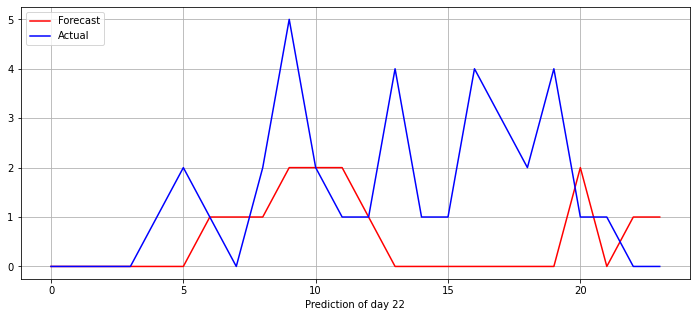

In [64]:
predictions = model.predict(x=X_test, batch_size=batch_size, verbose=0).reshape(-1,24)
log1p_mse_rmse(Y_test, predictions)
plotDayPrediction(predictions, Y_test, 22, True)